# Worksheet 3 &mdash; Ferromagnetic Hysteresis Ratio
William Thompson &nbsp;&nbsp;&nbsp;&nbsp;
10091404&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
12wt9@queensu.ca

<figure style="width:400px;max-width:50%;float:right; text-align:center; border: 1px solid #555;background:#EEE">
    <img src="./copper.png"/>
    <figcaption>
        Figure 1: Example of Hysteresis Curve
    </figcaption>
</figure>


**Table of Contents:**
1. [Preamble](#1-–-Preamble)
     0. [Modules](#1A-–-Modules)
     0. [Units](#1B-–-Units)
2. [Functions](#2-–-Functions)
    0. [Model](#2A-–-Model)
    0. [Data Processing Functions](#2B-–-Data-Processing-Functions)
    0. [Data Analysis Functions](#2C-–-Data-Analysis-Functions)
3. [Data](#3-–-Data)
    0. [Provided Values](#3A-–-Provided-Values)
    0. [Accepted Values](#3B-–-Accepted-Values)
    0. [Readings](#3C-–-Readings)
    0. [Area and Length Measurements](#3D-–-Area-and-Length-Measurements)
    0. [Initial Magnetization](#3E-–-Initial-Magnetization)
    
4. [Analysis](#4-–-Analysis)
    0. [4A &ndash; Calculate $B$ and $H$](#4A-–-Calculate-$B$-and-$H$)
    0. [ Select the turning points](#4B-–-Select-the-turning-points)
    0. [ Split into top and bottom curves](#4C-–-Split-into-top-and-bottom-curves)
    0. [Hysteresis Curves, $B_r$, $H_c$, $A$](#4D-–-Hysteresis-Curves,-$B_r$,-$H_c$,-$A$)
    0. [Question 2](#4E-–-Question-2)
    0. [Question 3](#4F-–-Question-3)
    0. [Question 4](#4G-–-Question-4)
    0. [Question 7](#4H-–-Question-7)

# 1 &ndash; Preamble

### 1A &ndash; Modules
Import NumPy, Matplotlib, SymPy, and more

In [1]:
%pylab inline
import re
import sympy
from IPython.display import display, Markdown, Latex, Image
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.constants
from ipywidgets import IntSlider, interact
import scipy.stats as stats

# Set all figures to a default size of 
rcParams['figure.figsize'] = 14, 8

Populating the interactive namespace from numpy and matplotlib


### 1B &ndash; Units
Define units to convert measurements to SI

In [2]:
s = 1        # Seconds
m = 1        # Meters
cm = 1e-2*m  # Centimeters
mm = 1e-3*m  # Milimeters
T = 1        # Teslas
nT = 1e-9    # Nanoteslas
V = 1        # Volts
mV = V*1e-3  # Milivolts
Ω = 1        # Ohms
MΩ = Ω*1e6   # Megaohms
F = 1        # Farads
μF = F*1e-6  # Micofarads

# 2 &ndash; Functions
### 2A &ndash; Model

In [3]:
def H(n_1, L, L_d, S, S_d, V_s):
    h = n_1 * V_s / (L*S)
    h_d = h * sqrt( (L_d/L)**2 + (S_d/S)**2)
    return h, h_d

In [4]:
def B(R, R_d, C, C_d, n_2, A_c, A_c_d, V_c):
    b = R*C*V_c/(n_2*A_c)
    b_d = b*sqrt( (R_d/R)**2 + (C_d/C)**2 + (A_c_d/A_c)**2)
    return b, b_d

In [5]:
def P(A, A_d, V, V_d, f):
    p = A*V*f
    p_d = p*sqrt( (A_d/A)**2 + (V_d/V)**2 )
    return p, p_d 

In [6]:
def μ_r(B, B_d, H, H_d):
    μ = B/(H*scipy.constants.mu_0)
    μ_d = μ * sqrt( (B_d/B)**2 + (H_d/H)**2)
    return μ, μ_d

### 2B &ndash; Data Processing Functions
Read data in from CSV into a dictionary of vectors:

In [7]:
def open_from_csv(filename):
    data = {}
    data['t'], data['V_s'], data['V_c'] = loadtxt(
        filename,
        delimiter=',',
        unpack=True,
        skiprows=2
    )
    data['t'] *= s  # Seconds
    data['V_s'] *= V # Volts
    data['V_c'] *= V # Volts
    
    data['name'] = filename.split('.')[-2]
    return data

Convert a float into a latex exponential notation: **`latex_exp(2.3e-3)` &rarr; $2.3\times10^{-3}$**

In [8]:
def latex_exp(x, pres=2):
    exp = int(math.log10(abs(x))) 
    mant = abs(x) / 10**exp * sign(x)
    return ('{:.'+str(pres)+'f} \\times 10^{{{:d}}}').format(mant, exp)

In [9]:
def display_tabular_data(headers, data):
    output = '|'+'|'.join(str(h) for h in headers)+'|\n' +\
             '|'+'|'.join('-' for h in headers)+'|\n'
    output += '\n'.join('|'+'|'.join(str(v) for v in row)+'|' for row in data)
    return Markdown(output)

### 2C &ndash; Data Analysis Functions

Function that let's user drag a slider to select the turning points from the graph. Based off sample from OnQ.

In [10]:
def user_select_ciritical_indices(data, start_guess, delta_guess):
    @interact(
        start_index=(0,1000,5),
        delta=(0, 1000, 5)
    )
    def show_plot(start_index=start_guess, delta=delta_guess):
        n1=start_index
        n2 = n1 + delta
        n3 = n2 + delta
        
        title('Plot of B-H data for '+data['name'])
        xlabel('time (ms)', fontsize = 16)
        
        plot(data['t']*1000, data['B'], 'r', label='B')
        ylabel('B (T)', fontsize = 16)
        twinx()
        
        plot(data['t']*1000, data['H'], 'b', label='H')
        plot(data['t'][n1]*1000, data['H'][n1], 'ro')
        plot(data['t'][n2]*1000, data['H'][n2], 'ro')
        plot(data['t'][n3]*1000, data['H'][n3], 'ro')
        ylabel('H (A/m)', fontsize = 16)
        
        period = data['t'][start_index+delta] - data['t'][start_index] 

        data.update({
                'n1': n1,
                'n2': n2,
                'n3': n3,
                'period': period,
                'frequency': 1/period
            })

Split the data into top and bottom vectors. Adapted from OnQ.

In [11]:
def split_data_into_top_bottom(data):
    data['t_top'] = data['t'][data['n1']:data['n2']]
    data['B_top'] = data['B'][data['n1']:data['n2']]
    data['B_top_d'] = data['B_d'][data['n1']:data['n2']]
    data['H_top'] = data['H'][data['n1']:data['n2']]
    data['H_top_d'] = data['H_d'][data['n1']:data['n2']]
    data['t_bot'] = data['t'][data['n2']:data['n3']]
    data['B_bot'] = data['B'][data['n2']:data['n3']]
    data['B_bot_d'] = data['B_d'][data['n2']:data['n3']]
    data['H_bot'] = data['H'][data['n2']:data['n3']]
    data['H_bot_d'] = data['H_d'][data['n2']:data['n3']]

Display the hysteresis curve. Adapted from OnQ.

In [12]:
def hysteresis_curve(data):
    plot(
            data['H_bot'], data['B_bot'], 'r',
            data['H_top'], data['B_top'], 'b'
    )
    grid()
    xlabel('H (A/m)', fontsize = 16)
    ylabel('B (T)', fontsize = 16)
    title('Hysteresis Curve for '+data['name'])

Calculate the area of the hysteresis curve. Do Reimann sums under each curve, shifted above the x-axis. The difference is the area.

In [13]:
def calculatearea(data):
    area = abs(
        integrate.trapz(data['B_top']-min(data['B']), data['H_top'][::-1]) - 
        integrate.trapz(data['B_bot']-min(data['B']), data['H_bot'])
    )
    area_d = abs(
        integrate.trapz(data['B_top_d'], data['H_top'][::-1]) + 
        integrate.trapz(data['B_bot_d'], data['H_bot'])
    )
    text(min(data['H']), max(data['B'])*.4,
         "$A = "+latex_exp(area,3)+' \pm '+latex_exp(area_d,1)+'TA/m$',
         fontsize=14,
         backgroundcolor='w')
    data['A'] = area
    data['A_d'] = area_d

Function to determine the remenance of the material:

In [14]:
def remanance(data):
    closest_to_zero_index = abs(data['H_top']).argmin()
    data['B_r'] = data['B_top'][closest_to_zero_index]
    plot(0, data['B_r'], 'ro')
    text(min(data['H']), max(data['B'])*.8,
         "$B_r = "+latex_exp(data['B_r'], 3)+' T$',
         fontsize=14,
         backgroundcolor='w')

<br>
<br>
<br>
<br>
Function to determine the Coercive force for a given sample:

In [15]:
def coersive(data):
    closest_to_zero_index = abs(data['B_top']).argmin()
    data['H_c'] = data['H_top'][closest_to_zero_index]
    plot(data['H_c'], 0, 'ro')
    text(min(data['H']), max(data['B'])*.6,
         "$H_c = "+latex_exp(data['H_c'], 3)+' A/m$',
         fontsize=14,
         backgroundcolor='w')

# 3 &ndash; Data 
### 3A &ndash; Provided Values

In [16]:
S = 0.10*Ω
S_d = S*0.05

n_1 = 160
n_2 = 150

R = 1.00*MΩ
R_d = R*0.01

C = 0.50*μF
C_d = C*0.02

### 3B &ndash; Accepted Values

### 3C &ndash; Readings

In [17]:
Iron_bad = open_from_csv(r'Iron_bad.CSV')

Iron = open_from_csv(r'Iron.CSV')

Steel = open_from_csv(r'Steel.CSV')

During the experiment, the equipment was initially setup incorrectly. This resulted in bad data until the problem was corrected. New data was captured for each with the execption of Iron with no spacer. 
<br>Instead of this bad data, this analysis will proceed with data captured by another experimenter, Jesse Noël, with his permission.<br>
Both are shown below:

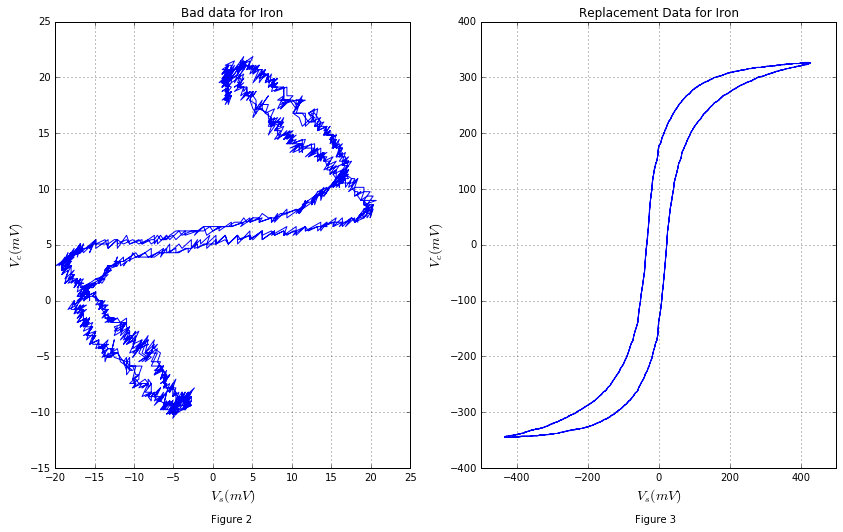

In [18]:
subplot(1, 2, 1)
plot(Iron_bad['V_s']*1000, Iron_bad['V_c']*1000)
xlabel('$V_s (mV)$', fontsize=14)
ylabel('$V_c (mV)$', fontsize=14)
grid()
title('Bad data for Iron')
figtext(0.28, 0.03, "Figure 2")

subplot(1,2, 2)
plot(Iron['V_s']*1000, Iron['V_c']*1000)
xlabel('$V_s (mV)$', fontsize=14)
ylabel('$V_c (mV)$', fontsize=14)
grid()
title('Replacement Data for Iron')
figtext(0.7, 0.03, "Figure 3");


iron_25W_lightbulb_comparison = 0.7 # About 70% as hot as the lightbulb
steel_25W_lightbulb_comparison = 1.5 # About 150% as hot as the lightbulb

Excerpt of Hysteresis Measurements for Iron:

In [19]:
display_tabular_data(
    ['Time (s)', '$V_s$ (Volts)', '$V_c$ (Volts)'],
    column_stack([
            Iron['t'][:10], Iron['V_s'][:10], Iron['V_c'][:10]
    ])
)

|Time (s)|$V_s$ (Volts)|$V_c$ (Volts)|
|-|-|-|
|-0.0263|-0.354|-0.332|
|-0.0263|-0.358|-0.332|
|-0.0263|-0.362|-0.333|
|-0.0262|-0.367|-0.334|
|-0.0262|-0.371|-0.335|
|-0.0262|-0.375|-0.336|
|-0.0262|-0.379|-0.337|
|-0.0261|-0.382|-0.338|
|-0.0261|-0.387|-0.338|
|-0.0261|-0.391|-0.339|

Excerpt of Hysteresis Measurements for Carbon Steel:

In [20]:
display_tabular_data(
    ['Time (s)', '$V_s$ (Volts)', '$V_c$ (Volts)'],
    column_stack([
            Steel['t'][:10], Steel['V_s'][:10], Steel['V_c'][:10]
    ])
)

|Time (s)|$V_s$ (Volts)|$V_c$ (Volts)|
|-|-|-|
|-0.025|-0.05313|-0.003125|
|-0.024975|-0.05391|-0.00390625|
|-0.02495|-0.05391|-0.00429688|
|-0.024925|-0.0543|-0.00507813|
|-0.0249|-0.05469|-0.00546875|
|-0.024875|-0.05547|-0.00585938|
|-0.02485|-0.05547|-0.00625|
|-0.024825|-0.05625|-0.00703125|
|-0.0248|-0.05586|-0.00703125|
|-0.024775|-0.05664|-0.00742188|

### 3D &ndash; Area and Length Measurements

In [21]:
# Measurements of the iron bar
#Iron: L=34.6cm +/- 0.15, A=8.4  +/- 0.21cm
Iron['A_c'] = 8.4*cm*cm
Iron['A_c_d'] = 0.21*cm*cm
Iron['L'] = 34.6*cm
Iron['L_d'] = 0.15*cm
Iron['V'] = Iron['A_c']*Iron['L']
Iron['V_d'] = Iron['V']*sqrt( (Iron['A_c_d']/Iron['A_c'])**2 + (Iron['L_d']/Iron['L'])**2)

# Measurements of the steel bar
#Steel: L=10cm, A=7.1 +/- 0.19cm
Steel['A_c'] = 7.1*cm*cm
Steel['A_c_d'] = 0.218*cm*cm
Steel['L'] = 10*cm
Steel['L_d'] = 0.15*cm
Steel['V'] = Steel['A_c']*Steel['L']
Steel['V_d'] = Steel['V']*sqrt( (Steel['A_c_d']/Steel['A_c'])**2 + (Steel['L_d']/Steel['L'])**2)


display_tabular_data(
    ['Measurment', 'Iron', 'Carbon Steel'],
    array([
            ['$A_c (m^2)$', '%.2e'%(Iron['A_c']), '%.2e'%(Steel['A_c'])],
            ['$\Delta A_c (m^2)$', '±%.0e'%(Iron['A_c_d']), '±%.0e'%(Steel['A_c_d'])],
            ['$L (m)$', '%.2e'%(Iron['L']), '%.2e'%(Steel['L'])],
            ['$\Delta L (m)$', '±%.0e'%(Iron['L_d']), '±%.0e'%(Steel['L_d'])],
            ['$V (m^3)$', '%.2e'%(Iron['V']), '%.2e'%(Steel['V'])],
            ['$\Delta V (m^3)$', '±%.0e'%(Iron['V_d']), '±%.0e'%(Steel['V_d'])],
        ])
)


|Measurment|Iron|Carbon Steel|
|-|-|-|
|$A_c (m^2)$|8.40e-04|7.10e-04|
|$\Delta A_c (m^2)$|±2e-05|±2e-05|
|$L (m)$|3.46e-01|1.00e-01|
|$\Delta L (m)$|±2e-03|±2e-03|
|$V (m^3)$|2.91e-04|7.10e-05|
|$\Delta V (m^3)$|±7e-06|±2e-06|

### 3E &ndash; Initial Magnetization

In [22]:
initial_magnetization = array([V, mV, mV]) *[
        [54.0, 410.0,  337.5],
        [57.2, 500.0,  343.8],
        [61.8, 670.0,  356.3],
        [66.4, 820.0,  362.5],
        [68.0, 850.0,  362.5],
        [71.0, 960.0,  362.5],
        [75.0, 1080.0, 368.8],
        [80.0, 1200.0, 368.8],
        [85.0, 1250.0, 368.8],
        [50.0, 300.0,  309.4],
        [45.0, 220.0,  287.5],
        [40.0, 170.0,  265.6],
        [35.0, 130.0,  237.5],
        [30.0, 88.0,   206.3],
        [25.0, 64.0,   175.0],
        [20.0, 49.0,   143.8]
]
initial_magnetization_Vs_d = 0.02
initial_magnetization_Vc_d = 0.1
display_tabular_data(
    ['Variac (Volts)', '$V_s$ (Volts)', '$V_c$ (Volts)'],
    initial_magnetization
)

|Variac (Volts)|$V_s$ (Volts)|$V_c$ (Volts)|
|-|-|-|
|54.0|0.41|0.3375|
|57.2|0.5|0.3438|
|61.8|0.67|0.3563|
|66.4|0.82|0.3625|
|68.0|0.85|0.3625|
|71.0|0.96|0.3625|
|75.0|1.08|0.3688|
|80.0|1.2|0.3688|
|85.0|1.25|0.3688|
|50.0|0.3|0.3094|
|45.0|0.22|0.2875|
|40.0|0.17|0.2656|
|35.0|0.13|0.2375|
|30.0|0.088|0.2063|
|25.0|0.064|0.175|
|20.0|0.049|0.1438|

# 4 &ndash; Analysis
### 4A &ndash; Calculate $B$ and $H$

In [23]:
for data in (Iron, Steel):
    data['H'], data['H_d']  = H(n_1, data['L'], data['L_d'], S, S_d, data['V_s'])
    data['B'], data['B_d']  = B(R, R_d, C, C_d, n_2, data['A_c'], data['A_c_d'], data['V_c'])

### 4B &ndash; Select the turning points

Iron:

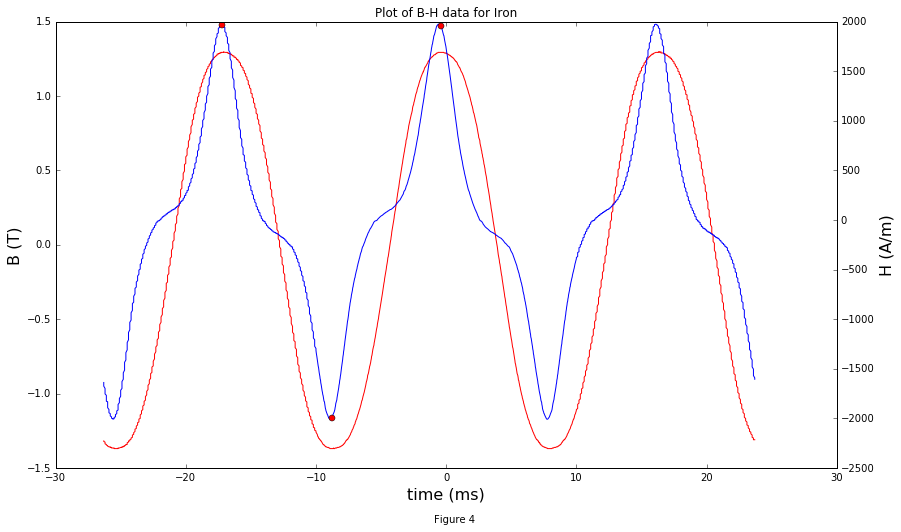

In [24]:
user_select_ciritical_indices(Iron, start_guess=365, delta_guess=335)
figtext(0.5, 0.03, "Figure 4");

Carbon Steel:

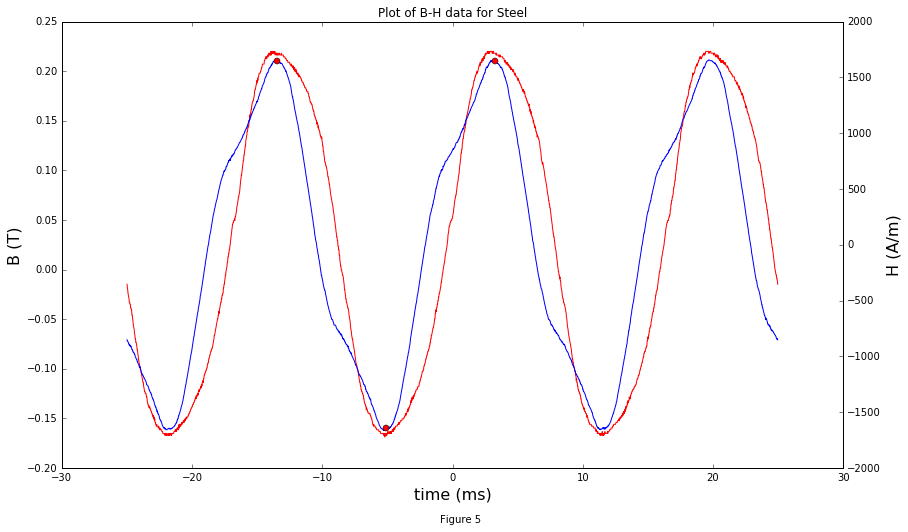

In [25]:
user_select_ciritical_indices(Steel, start_guess=460, delta_guess=335)
figtext(0.5, 0.03, "Figure 5");

### 4C &ndash; Split into top and bottom curves

In [26]:
split_data_into_top_bottom(Iron)
split_data_into_top_bottom(Steel)

### 4D &ndash; Hysteresis Curves, $B_r$, $H_c$, $A$

A plot of both curves, superimposed:

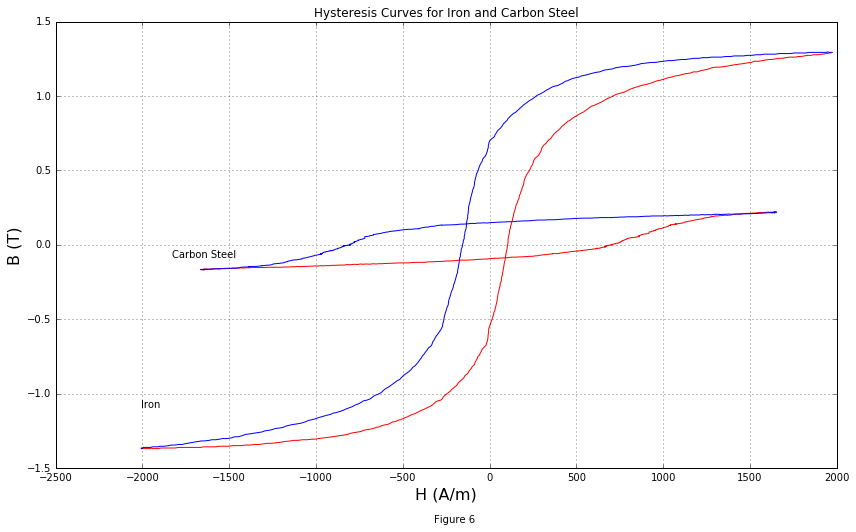

In [27]:
hysteresis_curve(Steel)
hysteresis_curve(Iron)
title('Hysteresis Curves for Iron and Carbon Steel')
text(min(Iron['H']), min(Iron['B'])*.8, 'Iron')
text(min(Steel['H'])*1.1, min(Steel['B'])*.5, 'Carbon Steel')
grid()
figtext(0.5, 0.03, "Figure 6");

**Hysteresis curve and calculations for Iron:**

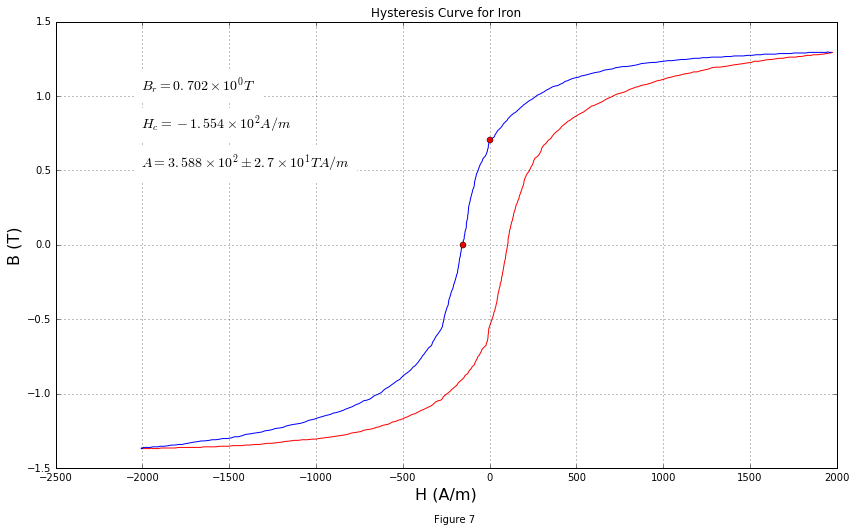

In [28]:
hysteresis_curve(Iron)
remanance(Iron)
coersive(Iron)
calculatearea(Iron)
figtext(0.5, 0.03, "Figure 7");

**Hysteresis curve and calculations for Carbon Steel:**

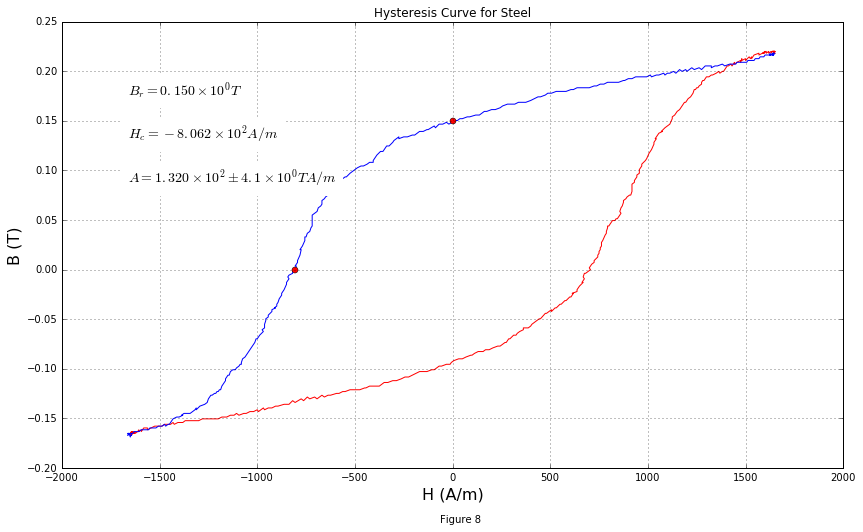

In [29]:
hysteresis_curve(Steel)
remanance(Steel)
coersive(Steel)
calculatearea(Steel)
figtext(0.5, 0.03, "Figure 8");

### 4E &ndash; Question 2
A good choice of material for a permenant magnet or magnetic memory device has a large $B_r$ so that it will remain strongly magnetized after the current is removed, and a large $H_c$ so that it is harder to demagnetize. 


A good choice of material for an electric motor has a small $H_c$ so that the field is easily reversed, a small area to limit the energy lost to heat, and each high $B$ values quickly to maximize the amplification effect.

According to these criteria:

In [30]:
magnet_best = (
    int(abs(Iron['H_c']) > abs(Steel['H_c'])) +
    int(Iron['B_r'] > Steel['B_r'])
) /2

motor_best = (
    int(Iron['H_c'] < Steel['H_c']) +
    int(max(Iron['B']) > max(Steel['B'])) +
    int(Iron['A'] < Steel['A'])
)/3

In [31]:
Markdown(
    'Iron is {:.0f}% the best choice for a permenant magnet or memory device.\n\n'
    'Iron is {:.0f}% the best choice for an electric motor.'
    .format(magnet_best*100, motor_best*100)
)

Iron is 50% the best choice for a permenant magnet or memory device.

Iron is 33% the best choice for an electric motor.

There is a tie between Iron and Carbon Steel for magnet or memory device. Steel has a larger $H_c$ but Iron has a larger $B_r$.

Carbon steel is a somewhat better choice for an electric motor. It has a larger $H_c$, a smaller area, but doesn't reach as high $B$ values.

### 4F &ndash; Question 3

In [32]:
Iron['P'], Iron['P_d'] = P(Iron['A'], Iron['A_d'], Iron['V'], Iron['V_d'], Iron['frequency'])
Steel['P'], Steel['P_d']  = P(Steel['A'], Steel['A_d'], Steel['V'], Steel['V_d'], Steel['frequency'])

Markdown(
    '$P_{{Iron}} = {} \pm {} W$\n\n'.format(latex_exp(Iron['P']), latex_exp(Iron['P_d'],0))+
    '$P_{{Steel}} = {} \pm {} W$'.format(latex_exp(Steel['P']), latex_exp(Steel['P_d'],0))
)

# (Iron['A'], Iron['A_d'], Iron['V'], Iron['V_d'], Iron['frequency'])

$P_{Iron} = 1.24 \times 10^{1} \pm 1 \times 10^{0} W$

$P_{Steel} = 1.12 \times 10^{0} \pm 1 \times 10^{-1} W$

The result for Iron seems reasonable: It felt less than the 25W lightbulb, and we calculated 12.4W.

The result for the carbon steel does not seem reasonable: It felt hotter than the 25W lightbulb and we calculated 1.1W, which is clearly incorrect. This indicates that using the magnetizing length for volume of hysteresis loss in Steel was incorrect.

### 4G &ndash; Question 4

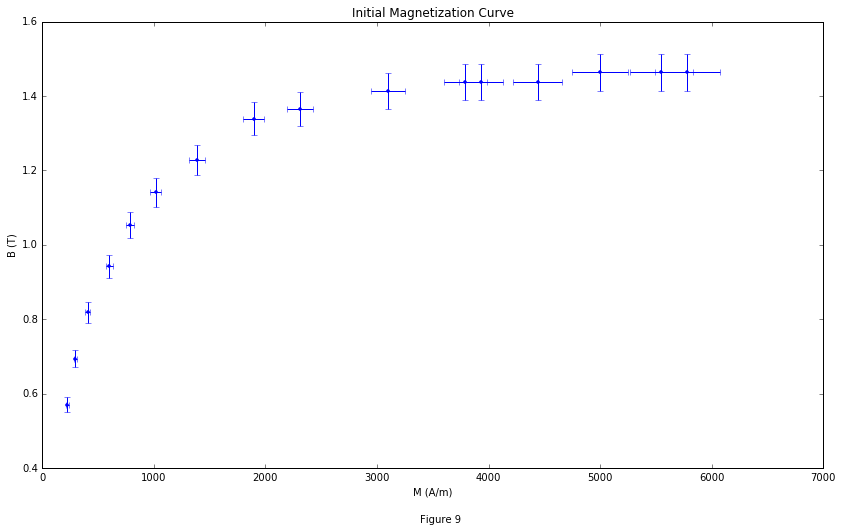

In [33]:
init_B, init_B_d = B(R, R_d, C, C_d, n_2, Iron['A_c'], Iron['A_c_d'], initial_magnetization[:,2])
init_H, init_H_d = H(n_1, Iron['L'], Iron['L_d'], S, S_d, initial_magnetization[:,1])
errorbar(init_H, init_B, init_B_d, init_H_d, fmt='b.')
title('Initial Magnetization Curve')
xlabel('M (A/m)')
ylabel('B (T)')
figtext(0.5, 0.03, "Figure 9");

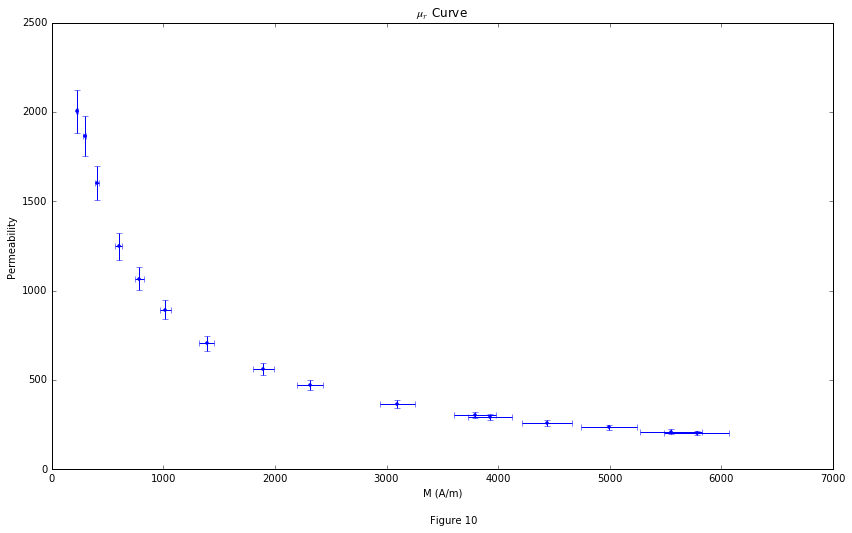

In [34]:
μ, μ_d = μ_r(init_B, init_B_d, init_H, init_H_d)
errorbar(init_H, μ, μ_d, init_H_d, fmt='b.')
title('$μ_r$ Curve')
xlabel('M (A/m)')
ylabel('Permeability')
figtext(0.5, 0.03, "Figure 10");

In [35]:
iimax = μ.argmax()
Markdown('$ \mu_r = '+latex_exp(max(μ))+' \pm '+latex_exp(μ_d[iimax],0)+
         '$\n\n It occurs at a flux density of $'+latex_exp(init_H[iimax],3)+
         ' \pm '+latex_exp(init_H_d[iimax],3)+' T$.')

$ \mu_r = 2.00 \times 10^{3} \pm 1 \times 10^{2}$

 It occurs at a flux density of $2.266 \times 10^{2} \pm 1.137 \times 10^{1} T$.

According to [Smithhells Metals Reference](https://app.knovel.com/web/view/swf/show.v/rcid:kpSMRBE012/cid:kt003OACU2/viewerType:pdf/root_slug:smithells-metals-reference?cid=kt003OACU2&page=5&b-toc-cid=kpSMRBE012&b-toc-root-slug=smithells-metals-reference&b-toc-url-slug=permanent-magnet-materials&b-toc-title=Smithells%20Metals%20Reference%20Book%20(8th%20Edition%29), the relative permeabillity of Iron, $\mu_r$, varies between 1560 and 2060 depending on the type of Iron, and it occurs at a flux density of 200-320 A/m. This agrees with the result, though a more accurate analysis would require knowing exactly what type of Iron the sample is.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


### 4H &ndash; Question 7

<br>

<figure style="width:400px;max-width:50%;float:left; text-align:center; border: 1px solid #555;background:#EEE">
    <img src="plastic.jpg"/>
    <figcaption>
        Figure 11: Plastic Spacer
    </figcaption>
</figure>

<figure style="width:400px;max-width:50%;float:right; text-align:center; border: 1px solid #555;background:#EEE">
    <img src="copper.png"/>
    <figcaption>
        Figure 12: Copper Spacer
    </figcaption>
</figure>

The hysteresis curve including the plastic spacer is far thinner, indicating that less energy is lost to heat. This is because the plastic spacer is an insulator which increases the linearity.

The copper spacer introduces losses to eddy currents, as such the area inside the hysteresis curve is larger.